# Reproducing Sample-efficiency curves and performance estimate with confidence intervals

## Sample efficiency curves

The result will be saved as `AugmentedSocialScientist/analysis/graphs/all_V2_meanpp.png`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
import statsmodels.stats.api as sms
import sys
import os
sys.path.append(os.path.realpath('..'))
%matplotlib inline

# WARNING : Make sure that your current working directory (cwd) is `ReproducingAugSS/AugmentedSocialScientist/`

from PATHS import REPO_PATH

sns.set_context("paper")
sns.set_palette("hls", 8)
sns.set_style("whitegrid")

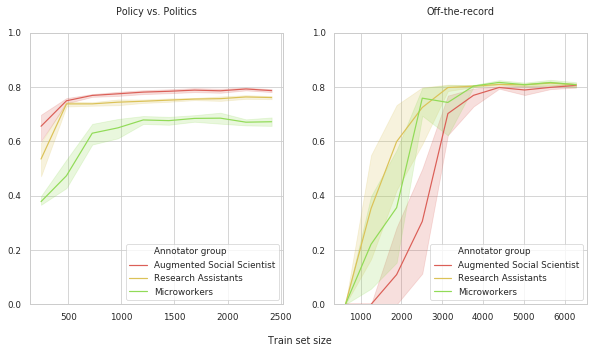

In [2]:
df_off = pd.read_json(os.path.join(REPO_PATH, 'AugmentedSocialScientist/saturation/off/logs_final.jsonl'), lines=True)
df_endoexo = pd.read_json(os.path.join(REPO_PATH, 'AugmentedSocialScientist/saturation/endoexo/logs_final.jsonl'), lines=True) 


# We discard outliers only on the following criteria : 
# We checked for the logs of our off experiences and our GPU cluster raised runtime errors 
# for some experiments (% of data > 40%). This experiments are logged with performances of 0,
# But this performances correspond to runtime error that did not enable the model to train after
# the first epoch


def is_outlier(x, var):
    col = 'F1_char_' + var
    if x.percent_of_data > 0.4 and x[col] == 0:
        return True
    else:
        return False

# Outlier discarding
df_off = df_off[df_off.apply(lambda x: is_outlier(x, 'off'), axis=1)==False]


# Sampling regularization 
equiv = df_endoexo.groupby(['percent_of_data']).train_size.mean().reset_index(name='mean0')
equiv.mean0 = equiv.mean0.apply(lambda x: floor(x))
df_endoexo = pd.merge(df_endoexo, equiv, left_on='percent_of_data', right_on='percent_of_data', how='left')

# Renaming columns for a better-looking plot:
dic_rename = {
        'F1_char_exogène': 'F1 Policy',
        'F1_char_endogène': 'F1 Politics',
        'mean0': 'Train set size',
        "exp_name": "Annotator group"
            }

dic_rename_off = {
        'F1_char_off': 'F1 Off',
        'train_size': 'Train set size',
        "exp_name": "Annotator group"
            }

dic_rename_exp = {
    'endoexo_ass' : "Augmented Social Scientist",
    'endoexo_3students': "Research Assistants",
    'endoexo_X34students' : "Microworkers",
    'off_ass' : "Augmented Social Scientist",
    'off_3students': "Research Assistants",
    'off_34students' : "Microworkers"
}

df_endoexo = df_endoexo.rename(dic_rename, axis=1)
df_endoexo['Annotator group'] = df_endoexo['Annotator group'].apply(lambda x: dic_rename_exp[x])
df_endoexo['F1 Policy vs. Politics'] = df_endoexo[['F1 Policy', 'F1 Politics']].mean(axis=1)
df_off = df_off.rename(dic_rename_off, axis=1)
df_off['Annotator group'] = df_off['Annotator group'].apply(lambda x: dic_rename_exp[x])

# Starting to plot the figure:
plt.rcParams['legend.loc'] = "lower right"
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Set axis lims
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)

# Set common labels
fig.text(0.5, 0.04, '\nTrain set size', ha='center', va='center')

# Plots
sns.lineplot(data=df_endoexo, x="Train set size", y="F1 Policy vs. Politics", hue="Annotator group", ax=ax1)
sns.lineplot(data=df_off, x="Train set size", y="F1 Off", hue="Annotator group", ax=ax2)

# Erase sns labels
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_ylabel('')
ax2.set_ylabel('')
# Plot-specific titles
ax1.set_title('Policy vs. Politics\n')
ax2.set_title('Off-the-record\n')
# Erase sns legends
ax1.legend(title='')
ax2.legend(title='')
plt.savefig(os.path.join(REPO_PATH, 'AugmentedSocialScientist/analysis/graphs/all_V2_meanpp.png'))
plt.show()

## Performances estimates & confidence intervals

The result will be saved as `AugmentedSocialScientist/analysis/graphs/perfs.md`.

In [3]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable


In [4]:

"""
Compute estimate + confidence interval for final perfs := 

"""
df_off = pd.read_json(os.path.join(REPO_PATH, 'AugmentedSocialScientist/saturation/off/logs_final.jsonl'), lines=True)
df_endoexo = pd.read_json(os.path.join(REPO_PATH, 'AugmentedSocialScientist/saturation/endoexo/logs_final.jsonl'), lines=True) 

def check_col_interest(c, col_int):
    for col in col_int:
        if col in c:
            return True
    else:
        return False

# We discard outliers only on the following criteria : 
# We checked for the logs of our off experiences and our GPU cluster raised runtime errors 
# for some experiments (% of data > 40%). This experiments are logged with performances of 0,
# But this performances correspond to runtime error that did not enable the model to train after
# the first epoch

def is_outlier(x, var):
    col = 'F1_char_' + var
    if x.percent_of_data > 0.4 and x[col] == 0:
        return True
    else:
        return False

# Outlier discarding
df_off = df_off[df_off.apply(lambda x: is_outlier(x, 'off'), axis=1)==False]


col_int = ['F1_char', 
           'F1_span', 
           'F1_span_T4', 
           'prec_', 
           'rec_', 
           "prec_span_", 
           "prec_span_T4_", 
           "rec_span_", 
           "rec_span_T4"]

interest_cols_off = [c for c in list(df_off.columns) if check_col_interest(c, col_int)]
interest_cols_ee = [c for c in list(df_endoexo.columns) if check_col_interest(c, col_int)]
with open(os.path.join(REPO_PATH, 'AugmentedSocialScientist/analysis/graphs/perfs.md'), 'w', encoding='utf-8') as f:
    for pcdata in [i*0.1 for i in range(1, 11)]:
        f.write(f"# Percent of training data : {pcdata} \n")
        # OFF
        final_off = df_off[df_off.percent_of_data == pcdata]
        f.write('## Off : \n\n')
        f.write("### Confidence intervals : \n")
        f.write((final_off.groupby('exp_name')[interest_cols_off].aggregate(lambda g:  sms.DescrStatsW(g).tconfint_mean()).to_markdown() ))
        f.write('\n\n')
        f.write("### Performance estimate:\n ")
        f.write((final_off.groupby('exp_name')[interest_cols_off].mean().to_markdown()))
        f.write('\n\n')

        # Policy-politics
        f.write("## Policy-politics : \n\n")
        final_ee = df_endoexo[df_endoexo.percent_of_data == pcdata]
        final_ee['F1_mean'] = final_ee[['F1_char_exogène', 'F1_char_endogène']].mean(axis=1)
        f.write("### Confidence intervals : \n")
        f.write((final_ee.groupby('exp_name')[interest_cols_ee + ['F1_mean']].aggregate(lambda g:  sms.DescrStatsW(g).tconfint_mean()).to_markdown()))
        f.write('\n\n')
        f.write("### Performance estimate:\n ")
        f.write((final_ee.groupby('exp_name')[interest_cols_ee + ['F1_mean']].mean().to_markdown()))
        f.write('\n\n')


/pbs/throng/humanum/anaconda/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/pbs/throng/humanum/anaconda/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/pbs/throng/humanum/anaconda/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se